# **Music Recommendation System using Hierachical Bandits**
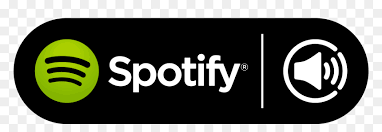

## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## **Read Data**

For this study, we are using the Spotify 2000 dataset from (https://www.kaggle.com/datasets/iamsumat/spotify-top-2000s-mega-dataset).  Let's take a look at the attributes it contains.

Our goal for this study is to partition the data in a hierarchical way, i.e., into a tree-like structure.  To this end, we want to exploit existing categories in the raw data.  If the provided granularity is not fine enough, we need to further segment the data, i.e., creating more intermediate levels in the tree.

In [2]:
data = pd.read_csv("data/Spotify-2000.csv")
data.head()

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
Index                     1994 non-null int64
Title                     1994 non-null object
Artist                    1994 non-null object
Top Genre                 1994 non-null object
Year                      1994 non-null int64
Beats Per Minute (BPM)    1994 non-null int64
Energy                    1994 non-null int64
Danceability              1994 non-null int64
Loudness (dB)             1994 non-null int64
Liveness                  1994 non-null int64
Valence                   1994 non-null int64
Length (Duration)         1994 non-null object
Acousticness              1994 non-null int64
Speechiness               1994 non-null int64
Popularity                1994 non-null int64
dtypes: int64(11), object(4)
memory usage: 233.8+ KB
None


In [4]:
len(np.unique(data['Top Genre']))

149

In [5]:
len(np.unique(data['Artist']))

731

In this dataset, two natural categories are "Top Genre" and "Artist", and each can serve as a level in the hierarchy, with genre being at a more general level, acting as a superset for artists.  The rationale is the following: music listeners are likely to enjoy songs that are somewhat similar, and an artist is likely to make songs in the same or similar genres. 

As we can see from the information printed above, there are 700s artist and around 150 genres, averaging about 5 artists per genre.  This is a reasonable number of arms of pulling in the genre level.

However since there are 150 genres, we cannot expect our MAB agent to pull 150 arms in the same level, so we need to further segment the genres into super-genres.

## **Characteristics of Different Genres**

The data set contains both genre information and sound attributes such as valence and dancibility.  We can try to see if we can discover any patterns by examining the sound attributes of each genre.

First, we compute averages of sound attributes for each genre.

Then, we visualize a handful of genres to see that there are different sound characteristics for different genres.

With this concept in mind, we can use the fact that we can classify genres using sound attributes to further segment the data, as described in the next section.

In [6]:
attr = ['Energy', 'Danceability', 'Loudness (dB)', 'Beats Per Minute (BPM)',
        'Liveness', 'Valence', 'Acousticness', 'Speechiness']

In [7]:
genre_data = data.groupby('Top Genre')[attr].mean()
genre_data = genre_data.reset_index()
genre_data

,Top Genre,Energy,Danceability,Loudness (dB),Beats Per Minute (BPM),Liveness,Valence,Acousticness,Speechiness
0,acid jazz,95.000000,66.000000,-5.000000,92.000000,14.000000,52.000000,13.000000,11.000000
1,acoustic pop,28.250000,48.750000,-11.250000,123.750000,16.500000,25.750000,58.250000,3.750000
2,adult standards,42.658537,49.162602,-11.504065,117.105691,19.243902,53.398374,51.382114,3.926829
3,afropop,70.000000,68.000000,-10.000000,154.000000,33.000000,51.000000,8.000000,3.000000
4,alaska indie,22.000000,46.000000,-10.000000,131.000000,11.000000,15.000000,90.000000,3.000000
...,...,...,...,...,...,...,...,...,...
144,stomp and holler,73.000000,48.000000,-5.000000,102.000000,21.000000,43.000000,3.000000,3.000000
145,streektaal,21.000000,61.000000,-20.000000,98.000000,8.000000,42.000000,60.000000,3.000000
146,trance,85.000000,60.000000,-6.000000,138.000000,6.000000,9.000000,1.000000,6.000000
147,uk pop,25.000000,53.000000,-16.000000,82.000000,12.000000,34.000000,52.000000,3.000000


In [8]:
top10 = genre_data[:10]

fig = px.bar(top10, x='Top Genre', y=attr, barmode='group')
fig.show()

## **Clustering Genres with K-Means**

Since genre characteristics can be read from sound attributes, we can apply K-means clustering algorithm to group similar genres together, making each cluster a super-genre.  The number of super genres is a tunnable hyperparameter, but 20 works fine for our case.

In [9]:
n_clusters = 20
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=n_clusters))])
X = genre_data[attr]
cluster_pipeline.fit(X)
genre_data['Cluster'] = cluster_pipeline.predict(X)

In [10]:
clusters = [None] * n_clusters
n_genres = [None] * n_clusters
for i in range(n_clusters):
    clusters[i] = genre_data[genre_data['Cluster'] == i]
    l = len(np.unique(clusters[i]['Top Genre']))
    n_genres[i] = l

print(n_genres)
print(clusters[14]['Top Genre'])

[11, 8, 3, 19, 7, 24, 5, 14, 5, 7, 3, 6, 6, 6, 8, 7, 4, 3, 1, 2]
0              acid jazz
27              basshall
29           belgian pop
36              boy band
75       detroit hip hop
99                g funk
112    indie anthem-folk
139               reggae
Name: Top Genre, dtype: object


As we can see, the segmentation is quite successful.  It divides the genres into super-genres, and the maximum number of genres belonging to a super-genre is about 20, which should be managable for MAB.

We can further examine that the genres grouped together are indeed similar, by inferring from their names.

Lastly, we write back the cluster information to the dataset.

In [11]:
data['Cluster'] = 0
for i in range(len(data)):
    genre = data['Top Genre'][i]
    genre_row = genre_data[genre_data['Top Genre'] == genre]
    data['Cluster'][i] = genre_row['Cluster']
data.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity,Cluster
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71,7
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39,5
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69,10
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76,3
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59,5


## **Build Recommender System**

Now we are ready to build the recommender system.

Our data is organized in the following way: all songs -> cluster i -> genre j -> artist k -> song l

The first step is to create a function that populates the rewards, Q, and arm arrays of each level.  Notice that Q and arm solely belong to their own level, whereas rewards need to be populated by considering the rewards from the subsets.

This function computes the rewards by simulating a user who has a favorite artist, and a favorite song created by the favorite artist. 

In [12]:
def init_info(fav_artist, fav_song):
    Qs = {}
    arms = {}

    Qs['root'] = np.zeros(n_clusters)
    arms['root'] = np.zeros(n_clusters)

    cluster_gb = data.groupby('Cluster')
    cluster_names = cluster_gb.groups.keys()

    cluster_rewards = [0] * len(cluster_names)
    genre_rewards = [None] * len(cluster_names)
    artist_rewards = [None] * len(cluster_names)
    song_rewards = [None] * len(cluster_names)

    for i, c in enumerate(cluster_names):
        cluster_data = cluster_gb.get_group(c)
        genre_gb = cluster_data.groupby('Top Genre')
        genre_names = genre_gb.groups.keys()

        Qs[(i)] = np.zeros(len(genre_names))
        arms[(i)] = np.zeros(len(genre_names))

        genre_rewards[i] = [0] * len(genre_names)
        artist_rewards[i] = [None] * len(genre_names)
        song_rewards[i] = [None] * len(genre_names)

        for j, g in enumerate(genre_names):
            genre_data = genre_gb.get_group(g)
            artist_gb = genre_data.groupby('Artist')
            artist_names = artist_gb.groups.keys()

            Qs[(i, j)] = np.zeros(len(artist_names))
            arms[(i, j)] = np.zeros(len(artist_names))

            artist_rewards[i][j] = [0] * len(artist_names)
            song_rewards[i][j] = [None] * len(artist_names)

            for k, a in enumerate(artist_names):
                artist_data = artist_gb.get_group(a)
                song_gb = artist_data.groupby('Title')
                song_names = song_gb.groups.keys()

                song_rewards[i][j][k] = [0] * len(song_names)

                for l, s in enumerate(song_names):
                    row = artist_data[artist_data['Title']==s].iloc[0]

                    reward = int(str(row['Artist']) == fav_artist)
                    if s == fav_song:
                        reward = 2

                    cluster_rewards[i] += reward
                    genre_rewards[i][j] += reward
                    artist_rewards[i][j][k] += reward
                    song_rewards[i][j][k][l] += reward

                Qs[(i, j, k)] = np.zeros(len(song_names))
                arms[(i, j, k)] = np.zeros(len(song_names))

    tree_rewards = [cluster_rewards, genre_rewards, artist_rewards, song_rewards]
    return Qs, arms, tree_rewards

Next, we modify the epsilon-decreasing algorithm, changing it into a recursive call.  Every time we want to compute the reward for a non-leaf level (not choosing individual songs, but choosing cluster, genre, or artist), we recursively invoke the `e_decay_bandit` function on a sub-branch, until the leaf-level returns the reward from the actual song chosen.

In [13]:
def e_decay_bandit(epsilon, indices):
    
    level = len(indices)
    if level == 0:
        branch = 'root'
    else:
        branch = tuple(indices) if level > 1 else indices[0]

    Q = Qs[branch]
    K = Q.size
    arm = arms[branch]
    is_leaf = (max_level == level)

    # Epsilon-decay action selection
    if K == 1:
        idx = 0
    elif np.random.random() > epsilon:
        if np.sum(Q) == 0:
            idx = np.random.randint(0, K)
        else:
            idx = np.argmax(Q)
    else:
        idx = np.random.randint(0, K)

    if is_leaf:
        # Reward and Q value update
        c, g, a = indices
        means = song_rewards[c][g][a]
        reward = means[idx]
    else:
        _, reward, _, _ = e_decay_bandit(epsilon, indices+[idx])

    arm[idx] += 1
    Q[idx] += 1/arm[idx]*(reward-Q[idx])
    
    return idx, reward, Q, arm


def parse_reward(indices):
    level = len(indices)
    means = None
    if level == 0:
        means = cluster_rewards
    elif level == 1:
        i = indices[0]
        means = genre_rewards[i]
    elif level == 2:
        i, j = indices
        means = artist_rewards[i][j]
    elif level == 3:
        i, j, k = indices
        means = song_rewards[i][j][k]
    return np.array(means)


def e_decay_run(c, M, N, indices):

    global Qs, arms, tree_rewards, cluster_rewards, \
         genre_rewards, artist_rewards, song_rewards

    means = parse_reward(indices)
    best = np.argmax(means)
    K = means.size
    d = np.max(means) - means[means.argsort()[-2]]

    percentage = np.zeros((M, N))
    regret = np.zeros((M, N))
    bestQ = np.zeros((M, N))

    # Keep track of action values and action counts
    for m in range(M):

        Qs, arms, tree_rewards = init_info('Ed Sheeran', 'Perfect')
        cluster_rewards, genre_rewards, artist_rewards, song_rewards = tree_rewards
        for n in range(N):
            epsilon = min(1, c*K/(d**2*n)) if n else 1
            idx, _, Q, arm = e_decay_bandit(epsilon, indices)   

            # Track frequency of choosing best arm and actual regret
            percentage[m, n] = arm[best]/(n+1)
            regret[m, n] = means[best]-means[idx]
            bestQ[m, n] = Q[best]
    print(best)
    return percentage, regret, bestQ

In [14]:
M, N = 1, 100
max_level = 3

Qs, arms, tree_rewards = init_info('Ed Sheeran', 'Perfect')
cluster_rewards, genre_rewards, artist_rewards, song_rewards = tree_rewards

In this test run, we first manually found the correct path of choices: (cluster -> genre -> artist -> song) to get the favorite song, and then train the e-decreasing agent on each level, on only the relevant branchs (other branch should all have value 0 and are pretty boring).  Then we plot the result in log-scaled graphs.

As we can see, each level is able to learn the correct choice, and combining these choices we are about to arrive at the favorite song.

Using this approch, the learning agent can encapsualate the user's preference in its parameters, and the "exploration" process can serve as recommendation of new songs.

In [21]:
#e_decay_run(0.2, 10, 1, [])
#e_decay_run(0.2, 10, 1, [5])
#e_decay_run(0.2, 10, 1, [5, 23])
#e_decay_run(0.2, 10, 1, [5, 23, 0])

5
23
0
6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



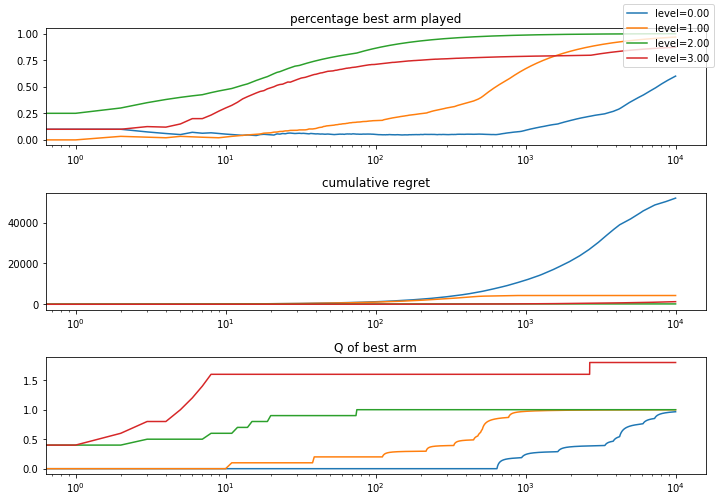

In [22]:
indices = [[], [5], [5, 23], [5, 23, 0]]

f = plt.figure(figsize=(10,7))
ax1 = f.add_subplot(311)
ax2 = f.add_subplot(312,sharex=ax1)
ax3 = f.add_subplot(313,sharex=ax1)

for i, idx in enumerate(indices):
    percentage, regret, bestQ = e_decay_run(0.2, 10, 100000, idx)
    ax1.plot(np.mean(percentage, axis=0), label="level=%.2f"%i)
    ax2.plot(np.cumsum(np.mean(regret, axis=0)))
    ax3.plot(np.mean(bestQ, axis=0))

ax1.set_xscale('log')
ax1.set_title("percentage best arm played")
ax2.set_title("cumulative regret")
ax3.set_title("Q of best arm")
f.legend()
f.tight_layout()
f.show()